# Simulation 2

In this simulation we evaluate the dynamics of convergence of a set of *preference matrices* towards a *consensus*. We analyze a iterative protocol in which preference matrices are project onto *ranking vector* and, at each iteration, a randomly selected ranking vector moves closer to the average by an $\epsilon$ step.

We start by importing some libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import data
import phasespace as ps
import normalizationlib as norm
import exploitationlib as expl

We set the parameters of the simulation: number of choices ($M$), number of experts ($E$), and step size ($\epsilon$).

In [2]:
n_experts = 6
n_choices = 5

stepsize = 0.01

We load randomly-generated *preference matrices* ($M \times M$) for each expert. A preference matrix encodes the preference of choice $i$ over choice $j$, for all $1 \leq i,j \leq M$. The data is returned in the form of a tensor $P$ ($M \times M \times E$).

In [3]:
P = data.randomdata(n_experts=n_experts, n_choices=n_choices)

We inspect the matrix of a random expert.

In [4]:
P[:,:,np.random.randint(n_experts)]

array([[0.5       , 0.75927424, 0.68731426, 0.15265396, 0.37581214],
       [0.24072576, 0.5       , 0.15232843, 0.27081248, 0.74519324],
       [0.31268574, 0.84767157, 0.5       , 0.84381876, 0.78473723],
       [0.84734604, 0.72918752, 0.15618124, 0.5       , 0.040977  ],
       [0.62418786, 0.25480676, 0.21526277, 0.959023  , 0.5       ]])

Notice that the diagonal is $0.5$ and that $p_{ij} + p_{ji} = 1$.

We now normalize the preference matrices into *stochastic matrices*, still producing a tensor of the same shape $S$ ($M \times M \times E$).

In [5]:
S = norm.centrality_tensor(P)

We look again at the matrix of a random expert.

In [6]:
S[:,:,np.random.randint(n_experts)]

array([[0.48550984, 0.23505578, 0.03405959, 0.24296384, 0.00241095],
       [0.01494422, 0.62194791, 0.1653729 , 0.11524453, 0.08249044],
       [0.21594041, 0.0846271 , 0.42677677, 0.07880019, 0.19385554],
       [0.00703616, 0.13475547, 0.17119981, 0.64877579, 0.03823277],
       [0.24758905, 0.16750956, 0.05614446, 0.21176723, 0.3169897 ]])

Notice that the sum along the rows is $1$.

Next, for each expert we compute a *ranking vector* using the *rank-centrality* (a.k.a., *Pagerank*, *Markov Chain stationary distribution*). This produces a new matrix $r$ ($M \times E$).

In [7]:
r = expl.RCT_3D(S)

/home/fmzennaro/gits/GDM/phase_space/exploitationlib.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  matrix[:,i] = n


We select the ranking for a random expert.

In [8]:
r[:,np.random.randint(n_experts)]

array([0.21455983, 0.22203131, 0.07996332, 0.34636255, 0.13708299])

The ranking vector is not actually a discrete ranking, it is, instead, a continuous vector expressing the absolute preference for choice $i$, for all $1 \leq i \leq M$. An actual ranking is simply derived from this vector by sorting.

We now compute the average preference matrix $\bar{P}$ and the average ranking vector $\bar{r}$ as proxy for the consensus.

In [9]:
mean_P = np.mean(P,axis=2)
mean_r = np.mean(r,axis=1)

We look at the mean preference matrix $\bar{P}$.

In [10]:
mean_P

array([[0.5       , 0.48678031, 0.59794312, 0.4151269 , 0.57624403],
       [0.51321969, 0.5       , 0.6121935 , 0.38959693, 0.39224722],
       [0.40205688, 0.3878065 , 0.5       , 0.59914783, 0.55030442],
       [0.5848731 , 0.61040307, 0.40085217, 0.5       , 0.65217429],
       [0.42375597, 0.60775278, 0.44969558, 0.34782571, 0.5       ]])

Diagonal is, as expect, $0.5$, and it still holds that that $p_{ij} + p_{ji} = 1$.

Let us turn to the mean ranking vector $\bar{r}$:

In [11]:
mean_r

array([0.20309598, 0.18142729, 0.20927145, 0.23765927, 0.168546  ])

It consistently sum up to one.

We now move on to analyze convergence taking the following step: 
1. We uniformly at random select an expert $e$
2. We consider its ranking vector $r_e$ and take an $\epsilon$-step towards the mean ranking vector $\bar{r}$: $$r'_e \leftarrow r_e + \epsilon (\bar{r}-r_e) $$,
3. We compute a new preference matrix $P'$ for expert $e$ mapping back the ranking vector $r'_e$
4. We re-evaluate the new mean preference matrices and mean ranking vectors.
All this steps are repeated until convergence.

In [12]:
preferences_in_time = [P.copy()]
consensus_in_time = [mean_r.copy()]

while(not(ps.check_convergence(r.T,mean_r,norm='l2',epsilon=0.01))):
    
    random_expert = ps.sample_point(n_experts)
    
    delta_r = np.linalg.norm(r[:,random_expert]-mean_r)

    rprime = ps.take_a_step(r[:,random_expert],mean_r,epsilon=stepsize)
    Pprime = ps.map_back(rprime)
    P[:,:,random_expert] = Pprime

    S = norm.centrality_tensor(P)
    r = expl.RCT_3D(S)
    
    mean_P = np.mean(P,axis=2)
    mean_r = np.mean(r,axis=1)
    
    preferences_in_time.append(P.copy())
    consensus_in_time.append(mean_r.copy())

We plot the standard deviation of each dimension of the ranking space. This gives an estimate of how much average ranking vector (i.e., consensus) oscillated during the run of the algorithm.

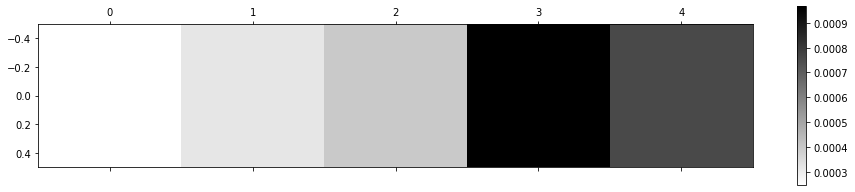

In [13]:
consensus_in_time = np.array(consensus_in_time)
plt.matshow(np.expand_dims(np.std(consensus_in_time,axis=0),axis=0), cmap='binary')
plt.colorbar()

We also visualize, expert by expert, the variation in their preference matrices between the original preference matrix and the final preference matrix.

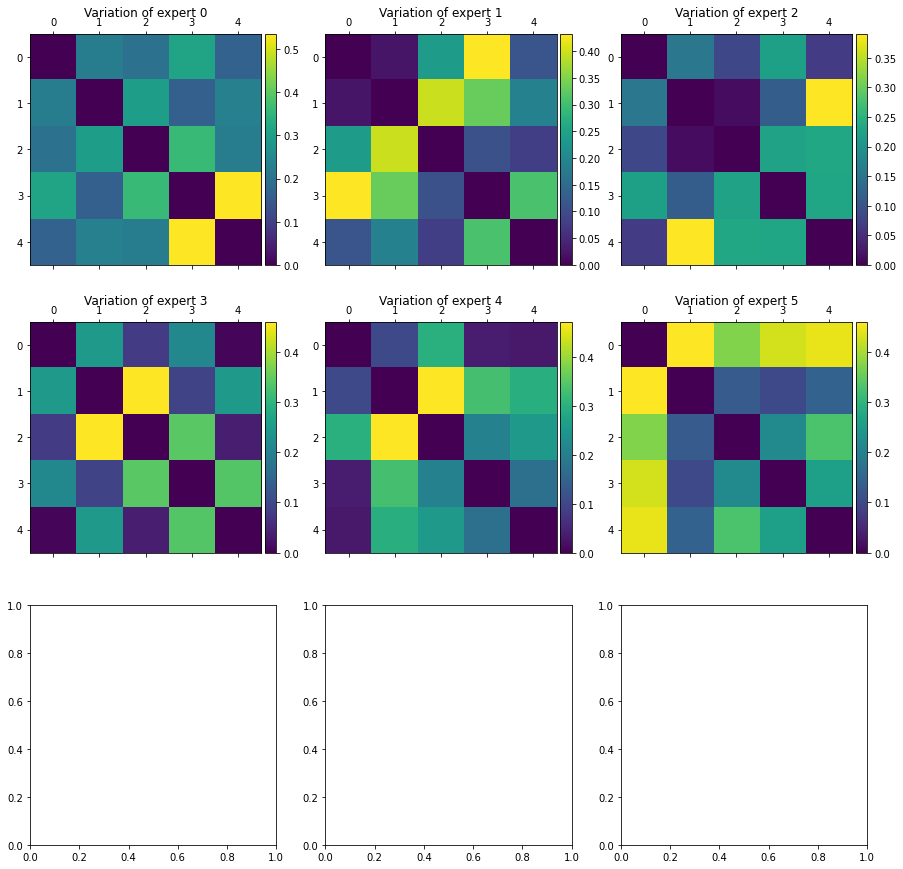

In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

squareside = np.ceil(np.sqrt(n_experts)).astype('int')
fig, ax = plt.subplots(squareside,squareside, figsize=(15,15))

for e in range(n_experts):
    im = ax[e//squareside, e%squareside].matshow(np.abs(preferences_in_time[0][:,:,e] - preferences_in_time[-1][:,:,e]))
    ax[e//squareside, e%squareside].set_title('Variation of expert {0}'.format(e))

    divider = make_axes_locatable(ax[e//squareside, e%squareside])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    

Notice the symmetric patterns.